In [33]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import adjusted_mutual_info_score as ami
import sys


sys.path.append('../src/Python')

from utils import *
from plot_utils import *
from hce_framework import HCE, rHCE, get_best_hce_level


# plt.rcParams['figure.dpi'] = 300 

# Help functions

In [2]:
Rt = lambda x, v: (
    np.array(
        [[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]] 
    ) @ v.reshape(-1, 1)).reshape(-1,)                      # Rotate vector v by angle x
Ty = lambda v: np.array([v[0] , -v[1]])                     # Reflect vector v across the x-axis
Tx = lambda v : np.array([-v[0] , v[1]])                    # Reflect vector v across the y-axis

# Example with the Karate club dataset

In [ ]:
G = nx.karate_club_graph()                               # Load the Karate Club graph
community_labels = {"Mr. Hi" : 0, "Officer" : 1}
gt_kclub_labels = np.array([community_labels[G.nodes[u]["club"]] for u in G.nodes])

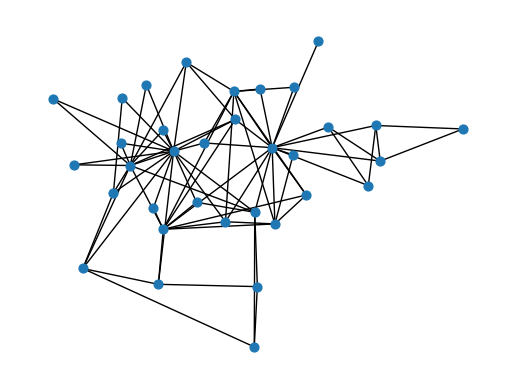

In [4]:
pos = nx.kamada_kawai_layout(G)
pos = {n : Rt(120 * np.pi / 180, pos[n]) for n in G.nodes}
pos = {n : Tx(pos[n]) for n in G.nodes}
pos = {n : Ty(pos[n]) for n in G.nodes}

nx.draw_networkx_nodes(G, pos=pos, node_size=40)
nx.draw_networkx_edges(G, pos=pos)

sns.despine(left=True, bottom=True)

In [5]:
N = len(G.nodes)
A = nx.adjacency_matrix(G).toarray()
A[A > 0] = 1
D = compute_dissimilarity_matrix(A)
H = linkage(D, method="average")

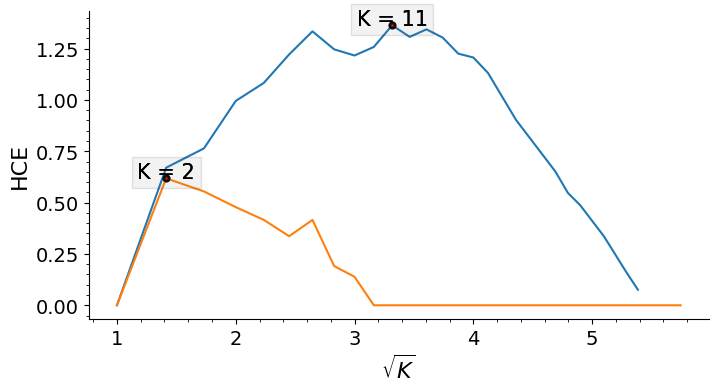

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
rn = 0      # Renormalization level
while True:
    if rn == 0:
        hce = HCE(H, (H.shape[0] + 1))
    else:
        hce = rHCE(H, (H.shape[0] + 1), rN)
    rN, _ = get_best_hce_level(hce)
    draw_HCE(
        hce,
        linewidth=2,
        fontticklabelsize=14,
        fontlabelsize=16,
        fonttextsize=15,
        f=np.sqrt,
        xlabel=r"$\sqrt{K}$",
        ax=ax
    )
    if rN == 2:
        break
    rn += 1

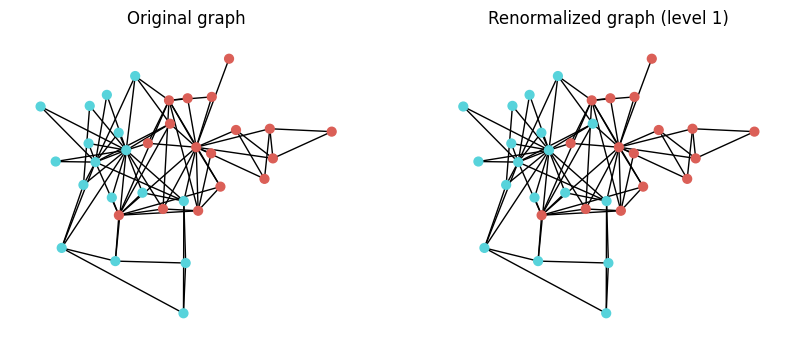

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title("Original graph", fontsize=12)
plot_network_linkage(G, H, nc=2, pos=pos, node_communities=gt_kclub_labels, node_size=40, linewidth=1, ax=axes[0])

axes[1].set_title(f"Renormalized graph (level 1)", fontsize=12)
plot_network_linkage(G, H, nc=2, pos=pos, node_communities=None, node_size=40, linewidth=1, ax=axes[1])

In [ ]:
labels = fast_cut_tree(H, n_clusters=2)
ami(gt_kclub_labels, labels)
print("AMI:", ami(gt_kclub_labels, labels))

# Hierarchical Nested Random Graph (HNRG)

In [8]:
N = 10 # Number of nodes of the finest level
R = 3  # Branching factor
L = 3  # Number of levels
hnrg_model = HNRG(N, R, L, seed=0)

In [30]:
G = nx.Graph(hnrg_model.A)
D = compute_dissimilarity_matrix(hnrg_model.A)
H = linkage(D, method="average")

# Compute the position of the nodes using t-SNE
pos = tsne_layout(squareform(D), random_state=10)

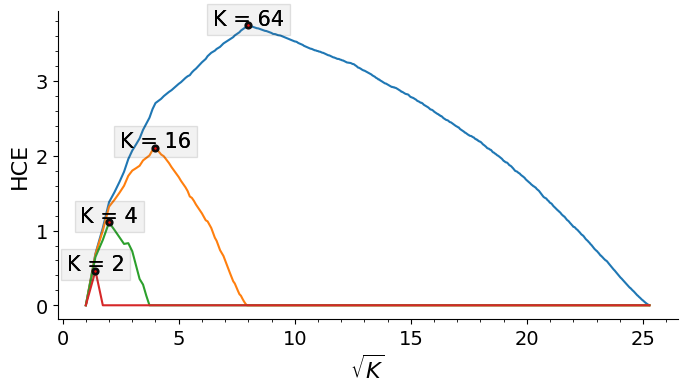

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
rn = 0      # Renormalization level
while True:
    if rn == 0:
        hce = HCE(H, (H.shape[0] + 1))
    else:
        hce = rHCE(H, (H.shape[0] + 1), rN)
    rN, _ = get_best_hce_level(hce)
    draw_HCE(
        hce,
        linewidth=2,
        fontticklabelsize=14,
        fontlabelsize=16,
        fonttextsize=15,
        f=np.sqrt,
        xlabel=r"$\sqrt{K}$",
        ax=ax
    )
    if rN == 2:
        break
    rn += 1

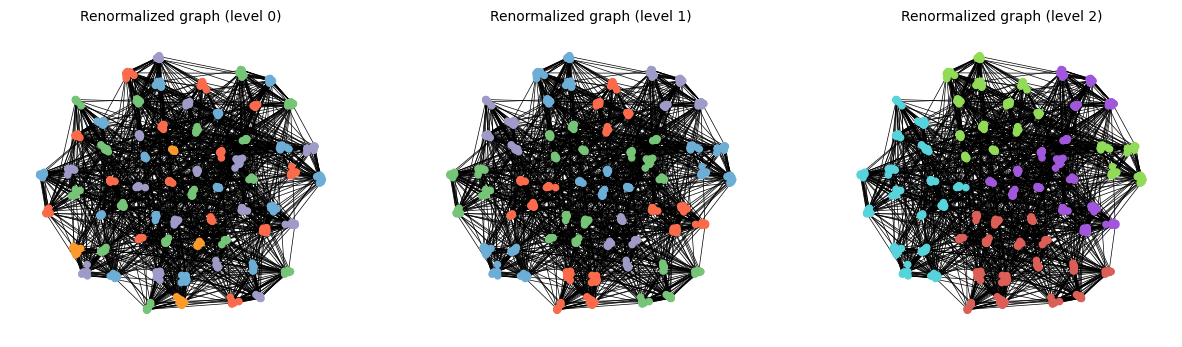

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].set_title("Renormalized graph (level 0)", fontsize=10)
labels = linear_partition(fast_cut_tree(H, n_clusters=64))
colors = graph_coloring_palette(pos, labels)
plot_network_linkage(G, H, nc=None, pos=pos, node_communities=labels, node_size=20, linewidth=0.5, ax=axes[0], cm=colors)

axes[1].set_title(f"Renormalized graph (level 1)", fontsize=10)
labels = linear_partition(fast_cut_tree(H, n_clusters=16))
colors = graph_coloring_palette(pos, labels)
plot_network_linkage(G, H, nc=None, pos=pos, node_communities=labels, node_size=20, linewidth=0.5, ax=axes[1], cm=colors)

axes[2].set_title(f"Renormalized graph (level 2)", fontsize=10)
labels = linear_partition(fast_cut_tree(H, n_clusters=4))
plot_network_linkage(G, H, nc=None, pos=pos, node_communities=labels, node_size=20, linewidth=0.5, ax=axes[2]) # graph coloring not needed for 4 communities

In [ ]:
labels = linear_partition(fast_cut_tree(H, n_clusters=64))
print("AMI(64):", ami(hnrg_model.hierarchical_communities_labels[:, -1], labels))
labels = linear_partition(fast_cut_tree(H, n_clusters=16))
print("AMI(16):", ami(hnrg_model.hierarchical_communities_labels[:, -2], labels))
labels = linear_partition(fast_cut_tree(H, n_clusters=4))
print("AMI(4):", ami(hnrg_model.hierarchical_communities_labels[:, -3], labels))

AMI(64): 0.0
AMI(16): 0.0
AMI(4): 0.0
